# Description

This notebook reads all gene correlations across all tissues and computes a single correlation matrix.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd

# from tqdm import tqdm

import conf
from entity import Gene

# Settings

In [ ]:
# mashr
EQTL_MODEL = "MASHR"
EQTL_MODEL_FILES_PREFIX = "mashr_"

# # elastic net
# EQTL_MODEL = "ELASTIC_NET"
# EQTL_MODEL_FILES_PREFIX = "en_"

EQTL_MODEL_FILES_PREFIX = None

In [ ]:
if EQTL_MODEL_FILES_PREFIX is None:
    EQTL_MODEL_FILES_PREFIX = PHENOMEXCAN["PREDICTION_MODELS_PREFIXES"][EQTL_MODEL]

In [ ]:
display(f"Using eQTL model: {EQTL_MODEL} / {EQTL_MODEL_FILES_PREFIX}")

In [3]:
INPUT_DIR = (
    conf.PHENOMEXCAN["LD_BLOCKS"]["BASE_DIR"] / f"{EQTL_MODEL_FILES_PREFIX}gene_corrs"
)
display(INPUT_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/data/phenomexcan/ld_blocks/gene_corrs')

# Load data

## Gene correlations

In [4]:
all_gene_corr_files = list(INPUT_DIR.rglob("*.pkl"))

In [5]:
len(all_gene_corr_files)

1078

In [6]:
all_gene_corr_files[:5]

[PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/data/phenomexcan/ld_blocks/gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr21.pkl'),
 PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/data/phenomexcan/ld_blocks/gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr4.pkl'),
 PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/data/phenomexcan/ld_blocks/gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr18.pkl'),
 PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/data/phenomexcan/ld_blocks/gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr10.pkl'),
 PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/data/phenomexcan/ld_blocks/gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr13.pkl')]

In [7]:
assert len(all_gene_corr_files) == 22 * 49

In [8]:
all_gene_corr_files_df = pd.DataFrame({"corr_file": [f for f in all_gene_corr_files]})

In [9]:
all_gene_corr_files_df = all_gene_corr_files_df.assign(
    file_name=all_gene_corr_files_df["corr_file"].apply(lambda x: x.name)
)

In [10]:
all_gene_corr_files_df = all_gene_corr_files_df.assign(
    tissue=all_gene_corr_files_df["file_name"].apply(
        lambda x: x.split("-chr")[0].split("gene_corrs-")[1]
    )
)

In [11]:
all_gene_corr_files_df = all_gene_corr_files_df.assign(
    chromosome=all_gene_corr_files_df["file_name"].apply(
        lambda x: int(x.split("-chr")[1].split(".")[0])
    )
)

In [12]:
assert all_gene_corr_files_df["tissue"].unique().shape[0] == 49

In [13]:
assert all_gene_corr_files_df["chromosome"].unique().shape[0] == 22
assert set(all_gene_corr_files_df["chromosome"]) == set(range(1, 23))

In [14]:
all_gene_corr_files_df.shape

(1078, 4)

In [15]:
all_gene_corr_files_df.head()

,corr_file,file_name,tissue,chromosome
0,/home/miltondp/projects/labs/greenelab/phenopl...,gene_corrs-Adrenal_Gland-chr21.pkl,Adrenal_Gland,21
1,/home/miltondp/projects/labs/greenelab/phenopl...,gene_corrs-Adrenal_Gland-chr4.pkl,Adrenal_Gland,4
2,/home/miltondp/projects/labs/greenelab/phenopl...,gene_corrs-Adrenal_Gland-chr18.pkl,Adrenal_Gland,18
3,/home/miltondp/projects/labs/greenelab/phenopl...,gene_corrs-Adrenal_Gland-chr10.pkl,Adrenal_Gland,10
4,/home/miltondp/projects/labs/greenelab/phenopl...,gene_corrs-Adrenal_Gland-chr13.pkl,Adrenal_Gland,13


## MultiPLIER Z

In [16]:
multiplier_z_genes = pd.read_pickle(
    conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"]
).index.tolist()

In [17]:
len(multiplier_z_genes)

6750

In [18]:
multiplier_z_genes[:10]

['GAS6',
 'MMP14',
 'DSP',
 'MARCKSL1',
 'SPARC',
 'CTSD',
 'EPAS1',
 'PALLD',
 'PHC2',
 'LGALS3BP']

## Get gene objects

In [19]:
multiplier_gene_obj = {
    gene_name: Gene(name=gene_name)
    for gene_name in multiplier_z_genes
    if gene_name in Gene.GENE_NAME_TO_ID_MAP
}

In [20]:
len(multiplier_gene_obj)

6454

In [21]:
multiplier_gene_obj["GAS6"].ensembl_id

'ENSG00000183087'

In [22]:
_gene_obj = list(multiplier_gene_obj.values())

genes_info = pd.DataFrame(
    {
        "name": [g.name for g in _gene_obj],
        "id": [g.ensembl_id for g in _gene_obj],
        "chr": [g.chromosome for g in _gene_obj],
    }
).dropna()

In [23]:
genes_info.shape

(6452, 3)

In [24]:
genes_info.head()

,name,id,chr
0,GAS6,ENSG00000183087,13
1,MMP14,ENSG00000157227,14
2,DSP,ENSG00000096696,6
3,MARCKSL1,ENSG00000175130,1
4,SPARC,ENSG00000113140,5


## Get tissues names

In [25]:
db_files = list(conf.PHENOMEXCAN["PREDICTION_MODELS"][EQTL_MODEL].glob("*.db"))

In [26]:
assert len(db_files) == 49

In [27]:
tissues = [str(f).split(EQTL_MODEL_FILES_PREFIX)[1].split(".db")[0] for f in db_files]

In [28]:
tissues[:5]

['Skin_Not_Sun_Exposed_Suprapubic',
 'Cells_EBV-transformed_lymphocytes',
 'Brain_Frontal_Cortex_BA9',
 'Kidney_Cortex',
 'Brain_Substantia_nigra']

# Average correlations per chromosome

In [29]:
corrs_per_chr = {}

for chr_num in range(1, 23):
    print(f"Chromosome: {chr_num}", flush=True)

    chr_files = all_gene_corr_files_df[all_gene_corr_files_df["chromosome"] == chr_num]
    print(f"Number of corrs files: {chr_files.shape}")

    multiplier_genes_in_chr = genes_info[genes_info["chr"] == str(chr_num)]
    print(f"Number of MultiPLIER genes: {multiplier_genes_in_chr.shape}")

    # create final dataframe with corrs for this chr
    chr_df = pd.DataFrame(
        data=0.0,
        index=multiplier_genes_in_chr["id"],
        columns=multiplier_genes_in_chr["id"],
    )

    print("Reading corrs per tissue", flush=True)
    for idx, tissue_corrs in chr_files.iterrows():
        tissue_corrs_df = pd.read_pickle(tissue_corrs["corr_file"])

        nan_values = tissue_corrs_df.isna()
        if nan_values.any().any():
            print(
                f"  WARNING ({tissue_corrs['tissue']}): has NaN values ({nan_values.sum().sum()})"
            )
            tissue_corrs_df = tissue_corrs_df.fillna(0.0)

        # align
        tissue_corrs_df = tissue_corrs_df.loc[chr_df.index, chr_df.columns]

        chr_df = chr_df + tissue_corrs_df
    #         chr_df = chr_df.where(chr_df.abs() > tissue_corrs_df.abs(), tissue_corrs_df).fillna(chr_df)

    chr_df = chr_df / float(chr_files.shape[0])
    chr_df_flat = pd.Series(squareform(chr_df.values, checks=False))
    display(chr_df_flat.describe())

    corrs_per_chr[chr_num] = chr_df

    print("\n")

Chromosome: 1
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (700, 3)
Reading corrs per tissue


count    244650.000000
mean          0.000062
std           0.016267
min          -0.604064
25%          -0.005203
50%           0.000000
75%           0.005283
max           0.662772
dtype: float64



Chromosome: 2
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (445, 3)
Reading corrs per tissue


count    98790.000000
mean        -0.000031
std          0.016511
min         -0.572576
25%         -0.005460
50%          0.000000
75%          0.005474
max          0.555836
dtype: float64



Chromosome: 3
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (393, 3)
Reading corrs per tissue


count    77028.000000
mean         0.000007
std          0.018638
min         -0.926208
25%         -0.005516
50%          0.000000
75%          0.005437
max          0.892995
dtype: float64



Chromosome: 4
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (244, 3)
Reading corrs per tissue


count    29646.000000
mean         0.000081
std          0.015757
min         -0.493401
25%         -0.005026
50%          0.000000
75%          0.005064
max          0.556111
dtype: float64



Chromosome: 5
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (306, 3)
Reading corrs per tissue


count    46665.000000
mean         0.000041
std          0.018839
min         -0.620978
25%         -0.005262
50%          0.000000
75%          0.005253
max          0.717110
dtype: float64



Chromosome: 6
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (339, 3)
Reading corrs per tissue


count    57291.000000
mean         0.000085
std          0.018855
min         -0.549863
25%         -0.005654
50%          0.000000
75%          0.005680
max          0.763644
dtype: float64



Chromosome: 7
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (281, 3)
Reading corrs per tissue


count    39340.000000
mean         0.000242
std          0.017489
min         -0.335488
25%         -0.005271
50%          0.000002
75%          0.005450
max          0.703423
dtype: float64



Chromosome: 8
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (222, 3)
Reading corrs per tissue


count    24531.000000
mean        -0.000046
std          0.015408
min         -0.497477
25%         -0.004892
50%          0.000012
75%          0.004903
max          0.653567
dtype: float64



Chromosome: 9
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (245, 3)
Reading corrs per tissue


count    29890.000000
mean        -0.000095
std          0.018607
min         -0.800607
25%         -0.005406
50%          0.000000
75%          0.005427
max          0.763849
dtype: float64



Chromosome: 10
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (245, 3)
Reading corrs per tissue


count    29890.000000
mean        -0.000005
std          0.017629
min         -0.798728
25%         -0.005992
50%          0.000000
75%          0.005860
max          0.707145
dtype: float64



Chromosome: 11
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (387, 3)
Reading corrs per tissue


count    74691.000000
mean         0.000085
std          0.019831
min         -0.805327
25%         -0.005683
50%          0.000000
75%          0.005740
max          0.626080
dtype: float64



Chromosome: 12
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (389, 3)
Reading corrs per tissue


count    75466.000000
mean        -0.000073
std          0.018400
min         -0.881911
25%         -0.005265
50%          0.000000
75%          0.005168
max          0.723507
dtype: float64



Chromosome: 13
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (118, 3)
Reading corrs per tissue


count    6903.000000
mean       -0.000031
std         0.021762
min        -0.484959
25%        -0.004572
50%         0.000000
75%         0.004676
max         0.497591
dtype: float64



Chromosome: 14
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (211, 3)
Reading corrs per tissue


count    22155.000000
mean         0.000050
std          0.018158
min         -0.733259
25%         -0.005152
50%          0.000000
75%          0.005261
max          0.481464
dtype: float64



Chromosome: 15
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (187, 3)
Reading corrs per tissue


count    17391.000000
mean         0.000092
std          0.023125
min         -0.753693
25%         -0.005577
50%          0.000000
75%          0.005513
max          0.530052
dtype: float64



Chromosome: 16
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (274, 3)
Reading corrs per tissue


count    37401.000000
mean        -0.000028
std          0.025896
min         -0.750217
25%         -0.005933
50%          0.000000
75%          0.005818
max          0.710003
dtype: float64



Chromosome: 17
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (411, 3)
Reading corrs per tissue


count    84255.000000
mean         0.000021
std          0.019209
min         -0.666764
25%         -0.005698
50%          0.000000
75%          0.005789
max          0.616416
dtype: float64



Chromosome: 18
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (96, 3)
Reading corrs per tissue


count    4560.000000
mean       -0.000165
std         0.014240
min        -0.165306
25%        -0.005642
50%        -0.000173
75%         0.005389
max         0.297951
dtype: float64



Chromosome: 19
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (540, 3)
Reading corrs per tissue


count    145530.000000
mean          0.000057
std           0.018714
min          -0.646847
25%          -0.006179
50%           0.000000
75%           0.006243
max           0.806689
dtype: float64



Chromosome: 20
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (187, 3)
Reading corrs per tissue


count    17391.000000
mean        -0.000008
std          0.021300
min         -0.512275
25%         -0.006265
50%         -0.000054
75%          0.005810
max          0.581009
dtype: float64



Chromosome: 21
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (62, 3)
Reading corrs per tissue


count    1891.000000
mean        0.000785
std         0.018951
min        -0.330358
25%        -0.005045
50%         0.000378
75%         0.006563
max         0.172858
dtype: float64



Chromosome: 22
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (170, 3)
Reading corrs per tissue


count    14365.000000
mean        -0.000173
std          0.024237
min         -0.659690
25%         -0.006331
50%         -0.000084
75%          0.006518
max          0.719813
dtype: float64

# Create full gene correlation matrix

This matrix has all genes in MultiPLIER Z

In [30]:
gene_corrs_df = pd.DataFrame(data=0.0, index=genes_info["id"], columns=genes_info["id"])

In [31]:
gene_corrs_df.shape

(6452, 6452)

In [32]:
gene_corrs_df.head()

id,ENSG00000183087,ENSG00000157227,ENSG00000096696,ENSG00000175130,ENSG00000113140,ENSG00000117984,ENSG00000116016,ENSG00000129116,ENSG00000134686,ENSG00000108679,...,ENSG00000111716,ENSG00000166796,ENSG00000114331,ENSG00000131584,ENSG00000165410,ENSG00000172757,ENSG00000147862,ENSG00000008323,ENSG00000167083,ENSG00000149257
id,,,,,,,,,,,,,,,,,,,,,
ENSG00000183087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000157227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000096696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000175130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000113140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
for chr_num, chr_data in corrs_per_chr.items():
    chr_data = chr_data.reindex(
        index=gene_corrs_df.index, columns=gene_corrs_df.columns
    )
    gene_corrs_df = gene_corrs_df + chr_data.fillna(0.0)

In [34]:
gene_corrs_df = gene_corrs_df.astype(np.float32)

In [35]:
gene_corrs_df.head()

id,ENSG00000183087,ENSG00000157227,ENSG00000096696,ENSG00000175130,ENSG00000113140,ENSG00000117984,ENSG00000116016,ENSG00000129116,ENSG00000134686,ENSG00000108679,...,ENSG00000111716,ENSG00000166796,ENSG00000114331,ENSG00000131584,ENSG00000165410,ENSG00000172757,ENSG00000147862,ENSG00000008323,ENSG00000167083,ENSG00000149257
id,,,,,,,,,,,,,,,,,,,,,
ENSG00000183087,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ENSG00000157227,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,-0.000683,0.0,0.0,0.0,0.0,0.0
ENSG00000096696,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ENSG00000175130,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.001079,0.0,...,0.0,0.0,0.0,-0.000171,0.000000,0.0,0.0,0.0,0.0,0.0
ENSG00000113140,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [36]:
assert np.all(gene_corrs_df.values.diagonal() == 1.0)

## Stats

In [37]:
_gene_corrs_flat = squareform(gene_corrs_df.values, checks=False)

In [38]:
pd.Series(_gene_corrs_flat).describe()

count    2.081093e+07
mean     1.812486e-06
std      4.384554e-03
min     -9.262078e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.929952e-01
dtype: float64

# Plot

In [39]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [40]:
genes_order = genes_info.sort_values("chr")["id"].tolist()

In [41]:
cmap = ListedColormap(["w", "r"])

[]

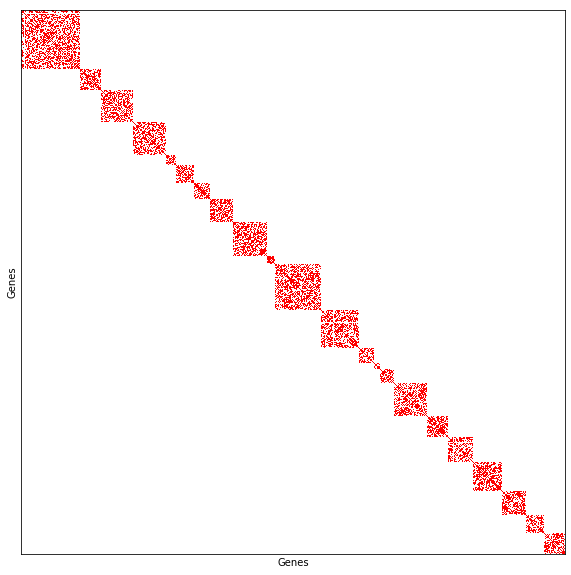

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(
    gene_corrs_df.loc[genes_order, genes_order].values, vmin=-0.05, vmax=0.05, cmap=cmap
)
ax.set_xlabel("Genes")
ax.set_ylabel("Genes")
ax.set_xticks([])
ax.set_yticks([])

# Testing

In [43]:
# COL4A1 and COL4A2
gene1 = "ENSG00000187498"
gene2 = "ENSG00000134871"

gene_corrs_df.loc[gene1, gene2]

0.20144808

In [44]:
_genes_files = all_gene_corr_files_df[all_gene_corr_files_df["chromosome"] == 13][
    "corr_file"
].tolist()
assert len(_genes_files) == 49

In [45]:
_gene_values = []
for f in _genes_files:
    gene1_gene2_corr = pd.read_pickle(f).loc[gene1, gene2]
    _gene_values.append(gene1_gene2_corr)

In [46]:
_gene_values = np.array(_gene_values)
assert _gene_values.shape[0] == 49

In [47]:
display(_gene_values.mean())
assert gene_corrs_df.loc[gene1, gene2] == _gene_values.mean()

0.20144808

# Save

## With ensemble ids

In [48]:
output_file = conf.PHENOMEXCAN["LD_BLOCKS"][EQTL_MODEL]["GENE_IDS_CORR_AVG"]
display(output_file)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/data/phenomexcan/ld_blocks/multiplier_genes-pred_expression_corr_avg.pkl')

In [49]:
gene_corrs_df.to_pickle(output_file)

## With gene symbols

In [50]:
output_file = conf.PHENOMEXCAN["LD_BLOCKS"][EQTL_MODEL]["GENE_NAMES_CORR_AVG"]
display(output_file)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/data/phenomexcan/ld_blocks/multiplier_genes-pred_expression_corr_avg-gene_names.pkl')

In [51]:
gene_corrs_gene_names_df = gene_corrs_df.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [52]:
assert gene_corrs_gene_names_df.index.is_unique

In [53]:
assert gene_corrs_gene_names_df.columns.is_unique

In [54]:
gene_corrs_gene_names_df.shape

(6452, 6452)

In [55]:
gene_corrs_gene_names_df.head()

id,GAS6,MMP14,DSP,MARCKSL1,SPARC,CTSD,EPAS1,PALLD,PHC2,LGALS3BP,...,LDHB,LDHC,ACAP2,ACAP3,CFL2,CFL1,NFIB,PLEKHG6,GNGT2,SERPINH1
id,,,,,,,,,,,,,,,,,,,,,
GAS6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
MMP14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,-0.000683,0.0,0.0,0.0,0.0,0.0
DSP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
MARCKSL1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.001079,0.0,...,0.0,0.0,0.0,-0.000171,0.000000,0.0,0.0,0.0,0.0,0.0
SPARC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [56]:
gene_corrs_gene_names_df.to_pickle(output_file)